<a href="https://colab.research.google.com/github/HH197/Unsupervised-cell-population-identification/blob/main/Unsupervised_cell_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.decomposition import PCA

from google.colab import drive

In [2]:
torch.manual_seed(197)

Mounting Google Drive so that I can read and write from GDrive.

In [3]:
# Mounting Google Drive
drive.mount('/content/gdrive')
base_dir = '/content/gdrive/My Drive/SL_project/'

Mounted at /content/gdrive


In [4]:
class CORTEX(Dataset):
    
    ''' 
    The Dataset class with necessary pre-processing steps for the gold standard
    Zeisel data set.
    
    '''
    
    def __init__ (self, 
                  file_dir= base_dir + "expression_mRNA_17-Aug-2014.txt", 
                  n_genes = 558):
    
        '''
        
        Performs the pre-processing steps which are:
        
        1. exctract the labels of the cell types from the data
        2. choose the genes that are transcribed in more than 25 cells 
        3. Select the `n_genes` genes with the highest Variance in the remaining genes from the previous step
        4. Log transform the data
        4. Perform random permutation of the genes 
        
        Attributes
        ----------
        file_dir : str 
            The path to the .csv file.
        n_genes : int 
            Number of the high variable genes that should be selected.
        n_cells
            Total number of cells.
        data: torch Tensor
            The data.
        labels: torch Tensor
            The labels.
        '''
        
        self.file_dir = file_dir
        self.n_genes = n_genes
        
        df = pd.read_csv(self.file_dir, delimiter= '\t', low_memory=False)
        
        # Groups of cells, i.e. labels
        Groups = df.iloc[7,]
        
        Groups = Groups.values[2:]
        _ , labels = np.unique(Groups, return_inverse=True)
        
        df1 = df.iloc[10:].copy()
        df1.drop(['tissue', 'Unnamed: 0'], inplace=True, axis=1)
        df1 = df1.astype(float)
        
        # choosing genes that are transcribed in more than 25 cells
        rows = np.count_nonzero(df1, axis=1) > 25 
        df1 = df1[np.ndarray.tolist(rows)]
        
        data = np.ndarray.astype(df1.values, float)
        data = np.log10(data + 1.0)

        # sorting the data based on the variance
        rows = np.argsort(np.var(data, axis = 1)*-1) 
        data = data[rows,:]
        data = data[0:self.n_genes, :] # choosing high variable genes 
        
        #permutation on features (they were sorted)
        np.random.seed(197)
        p = np.random.permutation(data.shape[0])
        data = data[p,:]
        
        y = data.T
        
        self.n_cells = y.shape[0]
        self.data = torch.from_numpy(y).float()
        self.labels = torch.tensor(labels)
        
    def __len__(self):
        return self.n_cells
    
    def __getitem__ (self, index):
        return self.data[index], self.labels[index]

In [5]:
def measure_q(data, Groups= None, n_clusters=7,  
              
              kmeans_kwargs = {"init": "random", 
                               "n_init": 50, 
                               "max_iter": 400, 
                               "random_state": 197}):

    '''
    This function will measure the quality of clustering using NMI, ARI, and ASW metrics. 
    
    Parameters
    ----------
    data : an array 
        The latent space of the model.
    
    Groups : an array
        The real lables.
    
    n_clusters : int
        The number of clusters in K-means.
    '''
    Groups = np.ndarray.astype(Groups, int)
            
    kmeans = KMeans(n_clusters, **kmeans_kwargs)
    kmeans.fit(data)
    
    NMI = metrics.cluster.normalized_mutual_info_score(Groups, kmeans.labels_)
    print(f'The NMI score is: {NMI}')
    
    ARI = metrics.adjusted_rand_score(Groups, kmeans.labels_)
    print(f'The ARI score is: {ARI}')
    
    ASW = metrics.silhouette_score(data, kmeans.labels_)
    print(f'The ASW score is: {ASW}')

In [12]:
def plot_line (x, *Y, 
               line_style = 'None',
               axis_x_ticks = None,
               color = None, 
               xlab = "Number of epochs", 
               ylab = 'Loss',
               save_fig = False, 
               path = './', 
               fig_name = 'fig.png'):
  '''
  A simple function to graph the plot lines with customized options.
  '''
  n = len(Y)
  
  if color == None:
    cmap = plt.cm.get_cmap('Set1') 
    color = cmap.colors
  else:
    if not isinstance(color, list): color = [color]
    color = color* (n//len(color))
    color = color + color[:n-len(color)] 
  
  fig, ax = plt.subplots(figsize=(7.48,5))

  for i, y in enumerate(Y):
    ax.plot(x, y, line_style, color = color[i])

  if axis_x_ticks != None: 
    ax.set_xticks(axis_x_ticks)
    ax.set_xticklabels(axis_x_ticks)
  
  ax.spines["top"].set_color(None)
  ax.spines["right"].set_color(None)
  ax.spines["bottom"].set_color("black")
  ax.spines["left"].set_color("black")
  ax.set_ylabel(ylab)
  ax.set_xlabel(xlab)
  
  if n>1:
    plt.gca().legend(('Train','Test'))

  if save_fig:
    plt.savefig(path + fig_name, bbox_inches='tight')

  plt.show()

# PCA 

In [7]:
cortex = CORTEX(n_genes=1024)

In [8]:
y, labels = next(iter(DataLoader(cortex, 
                                 batch_size= cortex.n_cells,
                                 shuffle=True)))
labels, y = labels.numpy(), y.numpy()


In [9]:
pca = PCA(n_components= 50)
pca.fit(y)

PCA(n_components=50)

In [10]:
ex_var = pca.explained_variance_ratio_
t = 0
for i, j in enumerate(ex_var):
  t += j
  ex_var[i] = t

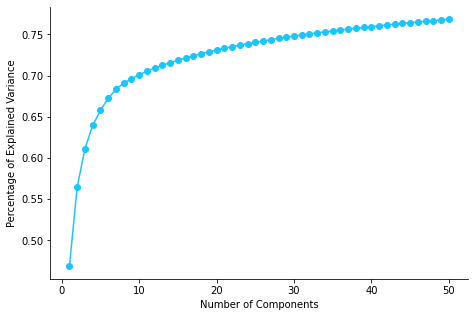

In [13]:
plot_line(range(1, len(ex_var)+1), 
          ex_var,
          line_style= "o-", 
          color = '#1ac6ff', 
          ylab = 'Percentage of Explained Variance', 
          xlab = 'Number of Components', 
          save_fig= True, 
          path = base_dir, 
          fig_name = 'PCA_EX_Var.png')

In [14]:
pca = PCA(n_components= 10)
latent = pca.fit_transform(y)

In [15]:
silhouette_coefficients = []
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 400, "random_state": 197}


for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(latent)
    score = metrics.silhouette_score(y, kmeans.labels_)
    silhouette_coefficients.append(score)

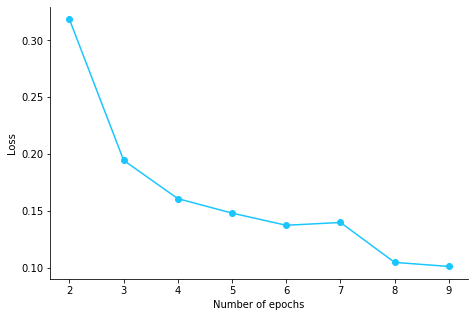

In [16]:
plot_line(range(2, 10), 
          silhouette_coefficients,
          line_style= "o-", 
          color = '#1ac6ff', 
          axis_x_ticks = range(2, 10), 
          save_fig= True, 
          path = base_dir, 
          fig_name = 'PCA_sli.png')

In [15]:
measure_q(latent, labels)

The NMI score is: 0.5598309300413099
The ARI score is: 0.4714555769718787
The ASW score is: 0.3055914640426636


# Autoencoders

In [17]:
class AE(nn.Module):

  def __init__(self, layers, rep_layer):
    """
    AutoEncoder model.

    The Class for creating, training, and validating autoencoder models.

    Parameters
    ----------

    layers : list 
      Layers of the encoder and decoder of the form [100,50,20], in which the numbers represent the number of neurons.

    rep_layer : int 
      representation layer's number of dimension.

    Attributes
    ----------

    encoder : Encoder of the AE.
    decoder : Decoder of the AE.

    Methods
    -------

    validate : Validates the model using test data and defined criterion.
    train : Trains the model with early stopping.

    """
    
    super().__init__()
    
    layer_list = [] # a list holding all layers
    len_model = len(layers)

    # encoder

    for i in range(len_model-1):
      layer_list.append(nn.Linear(layers[i], layers[i+1]))
      layer_list.append(nn.LeakyReLU(0.1))

    # representation layer
    layer_list.append(nn.Linear(layers[len_model-1], rep_layer))
    layer_list.append(nn.Identity())
    
    self.encoder = nn.Sequential(*layer_list)

    layers.append(rep_layer)
    layers.reverse()
    len_model = len(layers)
    layer_list.clear()

    # decoder layer
    for i in range(len_model-1):
      layer_list.append(nn.Linear(layers[i], layers[i+1]))
      layer_list.append(nn.LeakyReLU(0.1))
    
    self.decoder = nn.Sequential(*layer_list)
    

  def forward(self, x):
    
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return encoded, decoded

  def validate(self, test_data, criterion):

    """
    Validates the model with given test data and criterion. 

    test_data : Tensor
      The test data. 

    criterion : Pytorch loss function 
      Please refer to https://pytorch.org/docs/stable/nn.html#loss-functions
    """

    with torch.no_grad():
      encoded, decoded = self(test)
      eval_loss = criterion(decoded, test)
    return eval_loss.detach().item()

  def train(self, 
            train_dl, 
            test_data,
            optimizer,
            criterion, 
            epochs = 30, 
            patience = 3):

    """
    Trains the model

    This function will train the model using specefic number of epochs. 
    During the training it will validate the data and uses early stopping to 
    avoid overfitting. 

    Parameters
    ---------- 
    train_dl : Pytorch DataLoader class 
     Please visit Pytorch documentation. 
    test_data : Tensor
      The test data.
    optimizer : Pytorch optimizer 
      One of the various optimization algorithms implemented in `torch.optim`.
    criterion : Pytorch loss function 
      Please refer to https://pytorch.org/docs/stable/nn.html#loss-functions

    Returns
    -------
    losses : list 
      A list of training losses in each eopch.

    eval_losses : list 
      A list of validation losses in each eopch.
    """
        
    losses = []
    early_stop_cnt = 0
    eval_losses = []
    
    best_eval_loss = self.validate(test_data, criterion)

    for i in range(epochs):
      i+=1
      avg_loss = 0
      counter = 0

      for batch in train_dl:
        counter += 1 
        batch, _ = batch  
        encoded, decoded = self(batch)
        loss = criterion(decoded, batch)
        avg_loss += loss.detach().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
      avg_loss = avg_loss/counter 
      losses.append(avg_loss)

      if i%4 == 1:
            print(f'epoch: {i:3}  loss: {avg_loss:10.8f}')

      eval_loss = self.validate(test_data, criterion)
      eval_losses.append(eval_loss)

      if eval_loss < best_eval_loss:
        
        best_eval_loss = eval_loss
        #save model
      else:
        early_stop_cnt +=1

      if early_stop_cnt >= patience:
        break 

    return losses, eval_losses

In [18]:
n_genes = 3000
cortex = CORTEX(n_genes=n_genes)

In [19]:
test_size = int(cortex.n_cells *0.2)
train, test = random_split(cortex, [cortex.n_cells-test_size, test_size])

In [20]:
dl = DataLoader(train, batch_size=128, shuffle=True, drop_last=True)
test, _ = test[:]

## Vanilla

In [21]:
model = AE([n_genes], 32)
criterion = nn.MSELoss() # Mean Square Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

#### Training

In [22]:
losses, eval_losses = model.train(dl, test, optimizer, criterion, epochs = 100)

epoch:   1  loss: 0.27976453
epoch:   5  loss: 0.10337164
epoch:   9  loss: 0.07779962
epoch:  13  loss: 0.06999489
epoch:  17  loss: 0.06725243
epoch:  21  loss: 0.06413924
epoch:  25  loss: 0.06163051
epoch:  29  loss: 0.05949778
epoch:  33  loss: 0.05792957
epoch:  37  loss: 0.05680911
epoch:  41  loss: 0.05650362


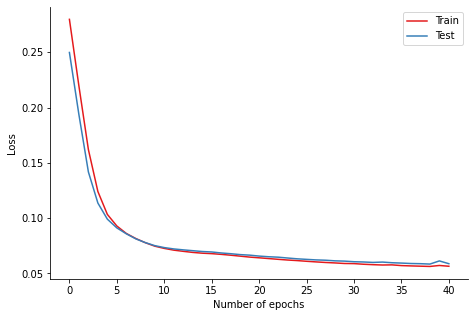

In [23]:
plot_line(range(len(losses)), 
          losses, 
          eval_losses, 
          save_fig= True, 
          path = base_dir, 
          fig_name = 'loss_vanilla.png')

In [24]:
y, labels = next(iter(DataLoader(cortex, 
                                 batch_size= cortex.n_cells,
                                 shuffle=True)))
labels = labels.numpy()

In [25]:
# finding the representation of the data from the trained model:
with torch.no_grad():  
  latent, _ = model(y)
latent = latent.numpy()

In [26]:
silhouette_coefficients = []
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 400, "random_state": 197}


for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(latent)
    score = metrics.silhouette_score(y, kmeans.labels_)
    silhouette_coefficients.append(score)

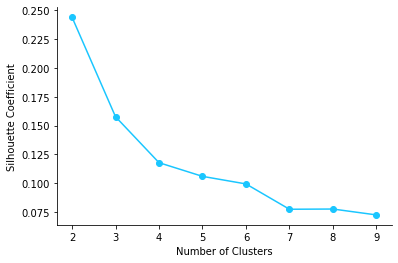

In [27]:
plot_line(range(2, 10), 
          silhouette_coefficients,
          line_style= "o-", 
          color = '#1ac6ff', 
          axis_x_ticks = range(2, 10), 
          ylab = "Silhouette Coefficient",
          xlab = "Number of Clusters", 
          save_fig= True, 
          path = base_dir, 
          fig_name = 'sil_vanilla.png')

In [28]:
measure_q(latent, labels)

The NMI score is: 0.48316295773272677
The ARI score is: 0.31287716899045886
The ASW score is: 0.25655311346054077


## Deep

In [24]:
model = AE([n_genes, 1024], 16)
criterion = nn.MSELoss() # Mean Square Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

In [25]:
losses, eval_losses = model.train(dl, test, optimizer, criterion, epochs = 100)

epoch:   1  loss: 0.14026407
epoch:   5  loss: 0.05698626
epoch:   9  loss: 0.05286349
epoch:  13  loss: 0.05147142
epoch:  17  loss: 0.04962677
epoch:  21  loss: 0.04872786


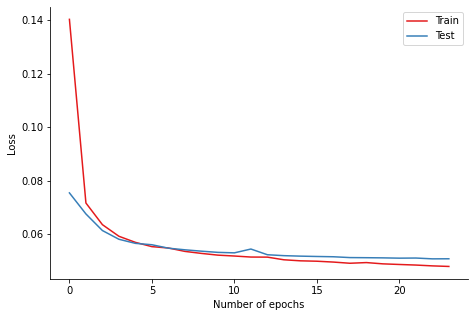

In [26]:
plot_line(range(len(losses)),
          losses, 
          eval_losses, 
          save_fig= True, 
          path = base_dir, 
          fig_name = 'loss_deep.png')

In [32]:
y, labels = next(iter(DataLoader(cortex, 
                                 batch_size= cortex.n_cells,
                                 shuffle=True)))
labels = labels.numpy()

In [33]:
# finding the representation of the data from the trained model:
with torch.no_grad():  
  latent, _ = model(y)
latent = latent.numpy()

In [34]:
silhouette_coefficients = []
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 400, "random_state": 197}


for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(latent)
    score = metrics.silhouette_score(y, kmeans.labels_)
    silhouette_coefficients.append(score)

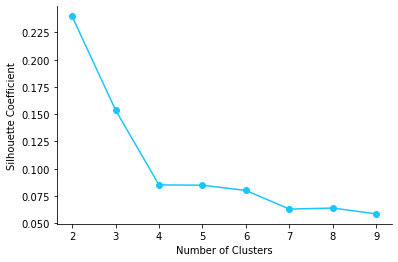

In [35]:
plot_line(range(2, 10), 
          silhouette_coefficients,
          line_style= "o-", 
          color = '#1ac6ff', 
          axis_x_ticks = range(2, 10), 
          ylab = "Silhouette Coefficient",
          xlab = "Number of Clusters", 
          save_fig= True, 
          path = base_dir, 
          fig_name = 'sil_deep.png')

In [36]:
measure_q(latent, labels)

The NMI score is: 0.7851868421703063
The ARI score is: 0.7332506049752114
The ASW score is: 0.237818643450737


# Comparison of the three methods

In [28]:
methods = ['PCA', 'Vanilla', 'Deep']
q_measurements = ['NMI', 'ARI', 'ASW']
data = [[0.5598, 0.4714, 0.3055],
        [0.4831, 0.3128, 0.2565],
        [0.7851, 0.7332, 0.2378]]

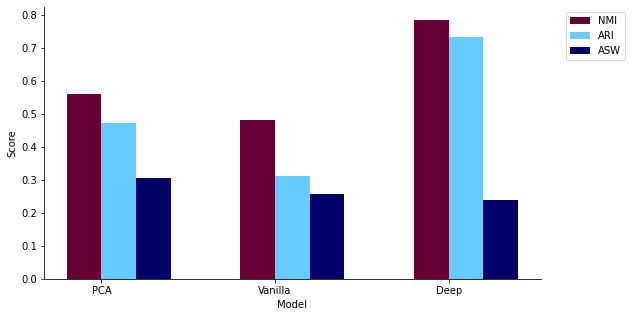

In [35]:
# cmap = plt.cm.get_cmap('tab10')
color = ['#660033', '#66ccff', '#000066']
  
fig, ax = plt.subplots(figsize=(8.9,5))

X_axis = np.arange(len(methods))
band = np.linspace(-0.1, 0.3, 3)

for i, y in enumerate(np.array(data).T):
  ax.bar(X_axis + band[i], y, 0.2, label = q_measurements[i], color = color[i])#color = cmap.colors[i])

ax.set_xticks(X_axis)
ax.set_xticklabels(methods)

ax.spines["top"].set_color(None)
ax.spines["right"].set_color(None)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
ax.set_ylabel('Score')
ax.set_xlabel('Model')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig(base_dir + 'comparison.png', bbox_inches='tight')
plt.show()